In [20]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math
import os

In [2]:
src_base_w = 32
src_base_h = 32
iso_base_w = 64 * 2
iso_base_h = 32 * 2

In [3]:
vertices = {
        1: ( np.array((0., 0., 1.)), np.array((1., 0., 0., 1.)), np.array((0., 0.)) ),
        2: ( np.array((1., 0., 0.)), np.array((0., 1., 0., 1.)), np.array((0., 1.)) ),
        3: ( np.array((0., 1., 0.)), np.array((0., 0., 1., 1.)), np.array((1., 0.)) ),
        4: ( np.array((1., 1., 1.)), np.array((1., 0., 1., 1.)), np.array((1., 1.)) ),
}

triangles = [
    [1, 2, 3],
    [2, 3, 4],
]

tridata = []

for triangle in triangles:
    points = [vertices[v][0] for v in triangle]
    colors = [vertices[v][1] for v in triangle]
    texture = [vertices[v][2] for v in triangle]
    v1 = points[1] - points[0]
    v2 = points[2] - points[0]
    cp = np.cross(v1, v2) # the cross product is a vector normal to the plane
    a, b, c = cp
    d = np.dot(cp, points[0])
    assert(d == np.dot(cp, points[1]))
    assert(d == np.dot(cp, points[2]))
    print(f"Main plane equation is {a}·x + {b}·y + {c}·z = {d}")
    main_plane = [cp, -d]
    
    M = np.transpose(np.linalg.inv(np.array([v1, v2, cp])))
    assert(np.linalg.norm(np.dot(M, v1) - np.array((1., 0., 0.))) < 1e-8)
    assert(np.linalg.norm(np.dot(M, v2) - np.array((0., 1., 0.))) < 1e-8)
    mapping_data = [points[0], M]
    colors_map   = [colors[0], colors[1] - colors[0], colors[2] - colors[0]]
    texture_map  = [texture[0], texture[1] - texture[0], texture[2] - texture[0]]

    side_planes = []
    for p1, p2, p3 in [
        (points[1], points[0], points[2]),
        (points[2], points[1], points[0]),
        (points[2], points[0], points[1]),
    ]:
        edge = p2 - p1
        normal = np.cross(edge, cp)
        constant = -np.dot(normal, p1)
        assert(constant == -np.dot(normal, p2))
        if np.dot(normal, p3) + constant < 0:
            normal = -normal
            constant = -constant
        a1, b1, c1 = normal
        k1 = constant
        v = np.dot(normal, p3) + constant
        print(f"Side plane equation is {a1}·x + {b1}·y + {c1}·z + {k1} >= 0 -> {v}")
        side_planes.append([normal, constant])
        
    tridata.append([main_plane, side_planes, mapping_data, colors_map, texture_map])

tridata

Main plane equation is 1.0·x + 1.0·y + 1.0·z = 1.0
Side plane equation is -1.0·x + 2.0·y + -1.0·z + 1.0 >= 0 -> 3.0
Side plane equation is -1.0·x + -1.0·y + 2.0·z + 1.0 >= 0 -> 3.0
Side plane equation is 2.0·x + -1.0·y + -1.0·z + 1.0 >= 0 -> 3.0
Main plane equation is 1.0·x + 1.0·y + -1.0·z = 1.0
Side plane equation is 1.0·x + 1.0·y + 2.0·z + -1.0 >= 0 -> 3.0
Side plane equation is 1.0·x + -2.0·y + -1.0·z + 2.0 >= 0 -> 3.0
Side plane equation is -2.0·x + 1.0·y + -1.0·z + 2.0 >= 0 -> 3.0


[[[array([1., 1., 1.]), -1.0],
  [[array([-1.,  2., -1.]), 1.0],
   [array([-1., -1.,  2.]), 1.0],
   [array([ 2., -1., -1.]), 1.0]],
  [array([0., 0., 1.]), array([[ 0.66666667, -0.33333333, -0.33333333],
          [-0.33333333,  0.66666667, -0.33333333],
          [ 0.33333333,  0.33333333,  0.33333333]])],
  [array([1., 0., 0., 1.]),
   array([-1.,  1.,  0.,  0.]),
   array([-1.,  0.,  1.,  0.])],
  [array([0., 0.]), array([0., 1.]), array([1., 0.])]],
 [[array([ 1.,  1., -1.]), -1.0],
  [[array([1., 1., 2.]), -1.0],
   [array([ 1., -2., -1.]), 2.0],
   [array([-2.,  1., -1.]), 2.0]],
  [array([1., 0., 0.]), array([[-0.66666667,  0.33333333, -0.33333333],
          [ 0.33333333,  0.33333333,  0.66666667],
          [ 0.33333333,  0.33333333, -0.33333333]])],
  [array([0., 1., 0., 1.]),
   array([ 0., -1.,  1.,  0.]),
   array([ 1., -1.,  1.,  0.])],
  [array([0., 1.]), array([ 1., -1.]), array([1., 0.])]]]

sin_angle = 1.0, cos_angle = 6.123233995736766e-17, cpls_angle = 1.0, cmns_angle = -0.9999999999999999


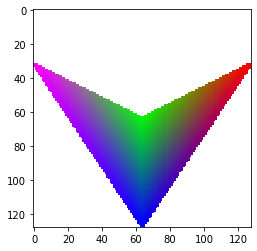

In [4]:
def draw_model_tile(tridata, subdiv=128, tiles_scale=1, hfactor=1.5, show_floor=True, angle=0.):
    xbase = 0
    ybase = 0

    sin_angle = math.sin(angle)
    cos_angle = math.cos(angle)
    cpls_angle = cos_angle + sin_angle
    cmns_angle = cos_angle - sin_angle
    radius_x = (iso_base_w * tiles_scale / 2)
    radius_y = (iso_base_h * tiles_scale / 2)
    max_z = 32 * hfactor

    print(f"sin_angle = {sin_angle}, cos_angle = {cos_angle}, cpls_angle = {cpls_angle}, cmns_angle = {cmns_angle}")

    img = Image.new('RGBA', (iso_base_w * tiles_scale, iso_base_h * tiles_scale * 2), (0, 0, 0, 0))
    pixels = img.load()

    x0 = radius_x * (1. + sin_angle)
    y0 = img.size[1] - radius_y * (1. - cos_angle)

    max_hc = subdiv
    for hc in range(0, max_hc):
        #print(f"hc = {hc}")
        h = float(hc / max_hc)

        max_vc = subdiv
        for raw_vc in range(max_vc):
            if cmns_angle >= 0:  vc = raw_vc
            else:                vc = max_vc - raw_vc - 1
            v = 1. - float(vc / max_vc)

            max_uc = subdiv
            for raw_uc in range(max_uc):
                if cpls_angle >= 0:  uc = raw_uc
                else:                uc = max_uc - raw_uc - 1
                u = 1. - float(uc / max_uc)

                e = 0
                if h > 0.99 or h < 0.01: e += 1
                if u > 0.99 or u < 0.01: e += 1
                if v > 0.99 or v < 0.01: e += 1
                if e >= 2:
                    alpha = 0.5
                    nr, ng, nb = 0, 0, 128
                else:
                    alpha = 0.
                    nr, ng, nb = 0, 0, 0
                
                point = np.array((u, v, h))
                for main_plane, side_planes, mapping_data, colors_map, texture_map in tridata:
                    d = np.dot(main_plane[0], point) + main_plane[1]
                    if abs(d) < .02:
                        out = False
                        for p in side_planes:
                            if np.dot(p[0], point) + p[1] < 0:
                                out = True
                        if not out:
                            p0, M = mapping_data
                            projA, projB, projC = np.dot(M, point - p0)
                            assert (projA >= 0. and projA <= 1.)
                            assert (projB >= 0. and projB <= 1.)
                            alpha = 1.
                            nr, ng, nb, alpha = 255 * (colors_map[0] + \
                                projA * colors_map[1] + projB * colors_map[2])
                            tu, tv = (texture_map[0] + \
                                projA * texture_map[1] + projB * texture_map[2])

                if alpha < 1:
                    continue
                            
                x = x0 + radius_x * (u * cmns_angle - v * cpls_angle)
                y = y0 - radius_y * (u * cpls_angle + v * cmns_angle)
                z = h * max_z

                tx = int(xbase + x)
                ty = int(ybase + y - z)
                
                pixels[tx, ty] = (int(nr), int(ng), int(nb), int(alpha))

    return img

img = draw_model_tile(tridata=tridata, tiles_scale=1, hfactor=2.0, show_floor=True, angle = 2 * math.pi/4.)
plt.imshow(img)
plt.show()


In [64]:
# See: https://github.com/totex/PyOpenGL_tutorials/blob/master/ObjLoader.py
class ObjLoader:
    def __init__(self):
        self.vert_coords = []
        self.text_coords = []
        self.norm_coords = []
        self.vert_colors = []

        self.vertex_index = []
        self.texture_index = []
        self.normal_index = []

        self.materials = {}

    def load_material(self, file):
        matname = os.path.splitext(os.path.basename(file))[0]
        matdata = None

        class Material:
            def __init__(self, path):
                self.path = path
                self.Ns = None
                self.Ni = None
                self.Ka = None
                self.Kd = None
                self.Ks = None
                self.Ke = None
                self.d = None
                self.illum = None
                self.map_Kd = None
            def __repr__(self):
                return f"Material['{self.map_Kd}']"
            def __str__(self):
                return f"Material['{self.map_Kd}']"
            def getKdImage(self):
                return Image.open(os.path.join(os.path.dirname(self.path), self.map_Kd))

        for line in open(file, 'r'):
            if line.lstrip().startswith('#'): continue
            values = line.split()
            if not values: continue

            if values[0] == 'newmtl':
                matname = values[1]
                matdata = Material(file)
            if values[0] == 'Ns':
                matdata.Ns = values[1]
            if values[0] == 'Ni':
                matdata.Ni = values[1]
            if values[0] == 'Ka':
                matdata.Ka = values[1:4]
            if values[0] == 'Kd':
                matdata.Kd = values[1:4]
            if values[0] == 'Ks':
                matdata.Ks = values[1:4]
            if values[0] == 'Ke':
                matdata.Ke = values[1:4]
            if values[0] == 'd':
                matdata.d = values[1]
            if values[0] == 'illum':
                matdata.illum = values[1]
            if values[0] == 'map_Kd':
                matdata.map_Kd = values[1]

        self.materials[matname] = matdata

    def load_model(self, file):
        normals = False
        texture = False
        vcolors = False
        for line in open(file, 'r'):
            if line.lstrip().startswith('#'): continue
            values = line.split()
            if not values: continue

            if values[0] == 'mtllib':
                mtllib = os.path.join(os.path.dirname(file), values[1])
                self.load_material(mtllib)
            if values[0] == 'usemtl':
                self.material = self.materials[values[1]]

            if values[0] == 'v':
                self.vert_coords.append(values[1:4])
                if len(values) >= 7:
                    vcolors = True
                    self.vert_colors.append(values[4:7])
            if values[0] == 'vt':
                texture = True
                self.text_coords.append(values[1:3])
            if values[0] == 'vn':
                normals = True
                self.norm_coords.append(values[1:4])

            if values[0] == 'f':
                face_i = []
                text_i = []
                norm_i = []
                for v in values[1:]:
                    w = v.split('/')
                    face_i.append(int(w[0])-1)
                    if texture:
                        text_i.append(int(w[1])-1)
                    if normals:
                        norm_i.append(int(w[2])-1)
                self.vertex_index.append([face_i])
                if texture:
                    self.texture_index.append([text_i])
                if normals:
                    self.normal_index.append([norm_i])

        self.vertex_index = [y for x in self.vertex_index for y in x]
        self.texture_index = [y for x in self.texture_index for y in x]
        self.normal_index = [y for x in self.normal_index for y in x]

        if texture:
            assert(len(self.vertex_index) == len(self.texture_index))
        if normals:
            assert(len(self.vertex_index) == len(self.normal_index))


vert_coords (8)   = [['1.000000', '0.000000', '0.000000'], ['1.000000', '0.000000', '1.000000'], ['0.000000', '0.000000', '1.000000'], ['0.000000', '0.000000', '0.000000'], ['1.000000', '2.000000', '0.000000'], ['1.000000', '2.000000', '1.000000'], ['0.000000', '2.000000', '1.000000'], ['0.000000', '2.000000', '0.000000']]
text_coords (20)   = [['0.0000', '0.0000'], ['0.0000', '1.0000'], ['1.0000', '1.0000'], ['1.0000', '0.0000'], ['0.0000', '0.0000'], ['0.0000', '1.0000'], ['1.0000', '1.0000'], ['1.0000', '0.0000'], ['0.0000', '1.0000'], ['1.0000', '1.0000'], ['1.0000', '0.0000'], ['0.0000', '0.0000'], ['0.0000', '1.0000'], ['1.0000', '0.0000'], ['0.0000', '0.0000'], ['0.0000', '1.0000'], ['1.0000', '1.0000'], ['0.0000', '1.0000'], ['1.0000', '1.0000'], ['1.0000', '0.0000']]
norm_coords (6)   = [['0.0000', '-1.0000', '0.0000'], ['0.0000', '1.0000', '0.0000'], ['1.0000', '0.0000', '0.0000'], ['-0.0000', '-0.0000', '1.0000'], ['-1.0000', '-0.0000', '-0.0000'], ['0.0000', '0.0000', '-1.0

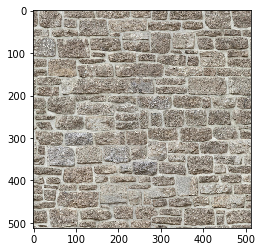

In [154]:
obj = ObjLoader()
obj.load_model("models/wall.obj")
img = obj.material.getKdImage()

print(f"vert_coords ({len(obj.vert_coords)})   = {obj.vert_coords}")
print(f"text_coords ({len(obj.text_coords)})   = {obj.text_coords}")
print(f"norm_coords ({len(obj.norm_coords)})   = {obj.norm_coords}")
print(f"vert_colors ({len(obj.vert_colors)})   = {obj.vert_colors}")
print(f"vertex_index ({len(obj.vertex_index)})  = {obj.vertex_index}")
print(f"texture_index ({len(obj.texture_index)}) = {obj.texture_index}")
print(f"normal_index ({len(obj.normal_index)})  = {obj.normal_index}")

texture_rgba = img.convert('RGBA')
plt.imshow(texture_rgba)
plt.show()


In [155]:
tridata = []

try: del points
except: pass
try: del texture
except: pass
try: del normals
except: pass
try: del colors
except: pass

for ivert, itex, inorm in zip(obj.vertex_index, obj.texture_index, obj.normal_index):
    points = np.array([obj.vert_coords[i] for i in ivert], dtype=np.float)
    texture = np.array([obj.text_coords[i] for i in itex], dtype=np.float)
    normals = np.array([obj.norm_coords[i] for i in inorm], dtype=np.float)
    colors = np.array([[0, 0, 0, 1], [1, 0, 0, 1], [0, 1, 0, 1], [0, 0, 1, 1]], dtype=np.float)
    #print(points, texture, normals)

    v1 = points[1] - points[0]
    v2 = points[2] - points[0]
    cp = np.cross(v1, v2) # the cross product is a vector normal to the plane
    a, b, c = cp
    d = np.dot(cp, points[0])
    for p in points:
        assert(d == np.dot(cp, p))
    print(f"Main plane equation is {a}·x + {b}·y + {c}·z = {d}")
    main_plane = [cp, -d]

    M = np.transpose(np.linalg.inv(np.array([v1, v2, cp])))
    assert(np.linalg.norm(np.dot(M, v1) - np.array((1., 0., 0.))) < 1e-8)
    assert(np.linalg.norm(np.dot(M, v2) - np.array((0., 1., 0.))) < 1e-8)
    mapping_data = [points[0], M]
    colors_map   = [colors[0], colors[1] - colors[0], colors[2] - colors[0]]
    texture_map  = [texture[0], texture[1] - texture[0], texture[2] - texture[0]]
    normals_map  = [normals[0], normals[1] - normals[0], normals[2] - normals[0]]

    ps = None
    if len(points) == 3:
        ps = [
            (points[1], points[0], points[2]),
            (points[2], points[1], points[0]),
            (points[2], points[0], points[1]),
        ]
    elif len(points) == 4:
        ps = [
            (points[1], points[0], points[2]),
            (points[2], points[1], points[0]),
            (points[3], points[2], points[0]),
            (points[3], points[0], points[1]),
        ]

    side_planes = []
    for p1, p2, p3 in ps:
        edge = p2 - p1
        normal = np.cross(edge, cp)
        constant = -np.dot(normal, p1)
        assert(constant == -np.dot(normal, p2))
        if np.dot(normal, p3) + constant < 0:
            normal = -normal
            constant = -constant
        a1, b1, c1 = normal
        k1 = constant
        for p in points:
            assert(np.dot(normal, p) + constant >= 0)
        print(f"Side plane equation is {a1}·x + {b1}·y + {c1}·z + {k1} >= 0")
        side_planes.append([normal, constant])

    tridata.append([main_plane, side_planes, mapping_data, normals_map, texture_map, colors_map])

tridata

Main plane equation is 0.0·x + -1.0·y + 0.0·z = 0.0
Side plane equation is -1.0·x + -0.0·y + -0.0·z + 1.0 >= 0
Side plane equation is 0.0·x + 0.0·y + -1.0·z + 1.0 >= 0
Side plane equation is 1.0·x + 0.0·y + -0.0·z + -0.0 >= 0
Side plane equation is -0.0·x + -0.0·y + 1.0·z + 0.0 >= 0
Main plane equation is 0.0·x + 1.0·y + 0.0·z = 2.0
Side plane equation is 0.0·x + 0.0·y + 1.0·z + -0.0 >= 0
Side plane equation is 1.0·x + -0.0·y + 0.0·z + -0.0 >= 0
Side plane equation is 0.0·x + 0.0·y + -1.0·z + 1.0 >= 0
Side plane equation is -1.0·x + 0.0·y + -0.0·z + 1.0 >= 0
Main plane equation is 2.0·x + 0.0·y + 0.0·z = 2.0
Side plane equation is -0.0·x + 0.0·y + 4.0·z + -0.0 >= 0
Side plane equation is 0.0·x + -2.0·y + 0.0·z + 4.0 >= 0
Side plane equation is 0.0·x + 0.0·y + -4.0·z + 4.0 >= 0
Side plane equation is -0.0·x + 2.0·y + -0.0·z + 0.0 >= 0
Main plane equation is 0.0·x + -0.0·y + 2.0·z = 2.0
Side plane equation is -4.0·x + 0.0·y + 0.0·z + 4.0 >= 0
Side plane equation is 0.0·x + -2.0·y + -0.0·

[[[array([ 0., -1.,  0.]), -0.0],
  [[array([-1., -0., -0.]), 1.0],
   [array([ 0.,  0., -1.]), 1.0],
   [array([ 1.,  0., -0.]), -0.0],
   [array([-0., -0.,  1.]), 0.0]],
  [array([1., 0., 0.]), array([[ 1., -0.,  1.],
          [-1., -0.,  0.],
          [-0., -1.,  0.]])],
  [array([ 0., -1.,  0.]), array([0., 0., 0.]), array([0., 0., 0.])],
  [array([0., 0.]), array([0., 1.]), array([1., 1.])],
  [array([0., 0., 0., 1.]), array([1., 0., 0., 0.]), array([0., 1., 0., 0.])]],
 [[array([0., 1., 0.]), -2.0],
  [[array([0., 0., 1.]), -0.0],
   [array([ 1., -0.,  0.]), -0.0],
   [array([ 0.,  0., -1.]), 1.0],
   [array([-1.,  0., -0.]), 1.0]],
  [array([1., 2., 0.]), array([[-1.,  0., -1.],
          [-0.,  0.,  1.],
          [-0.,  1.,  0.]])],
  [array([0., 1., 0.]), array([0., 0., 0.]), array([0., 0., 0.])],
  [array([0., 0.]), array([0., 1.]), array([1., 1.])],
  [array([0., 0., 0., 1.]), array([1., 0., 0., 0.]), array([0., 1., 0., 0.])]],
 [[array([2., 0., 0.]), -2.0],
  [[array([-0

sin_angle = 0.0, cos_angle = 1.0, cpls_angle = 1.0, cmns_angle = 1.0


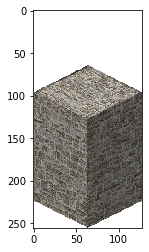

In [191]:
def draw_model_tile(tridata, subdiv=64, texture_rgba=None, tiles_scale=1, hfactor=1.5, show_floor=True, angle=0.):
    xbase = 0
    ybase = 0
    
    texture_w, texture_h = texture_rgba.size

    light_dir = np.array([1, 2, 0], dtype=np.float)
    light_dir = light_dir / np.linalg.norm(light_dir)

    sin_angle = math.sin(angle)
    cos_angle = math.cos(angle)
    cpls_angle = cos_angle + sin_angle
    cmns_angle = cos_angle - sin_angle
    radius_x = (iso_base_w * tiles_scale / 2)
    radius_y = (iso_base_h * tiles_scale / 2)
    max_z = 32 * hfactor

    print(f"sin_angle = {sin_angle}, cos_angle = {cos_angle}, cpls_angle = {cpls_angle}, cmns_angle = {cmns_angle}")

    img = Image.new('RGBA', (iso_base_w * tiles_scale, iso_base_h * tiles_scale * 4), (0, 0, 0, 0))
    pixels = img.load()

    x0 = radius_x * (1. + sin_angle)
    y0 = img.size[1] - radius_y * (1. - cos_angle)

    max_hc = subdiv * 2
    for hc in range(0, max_hc):
        #print(f"hc = {hc}")
        h = float(hc / max_hc) * 2

        max_vc = subdiv
        for raw_vc in range(max_vc):
            if cmns_angle >= 0:  vc = raw_vc
            else:                vc = max_vc - raw_vc - 1
            v = 1. - float(vc / max_vc)

            max_uc = subdiv
            for raw_uc in range(max_uc):
                if cpls_angle >= 0:  uc = raw_uc
                else:                uc = max_uc - raw_uc - 1
                u = 1. - float(uc / max_uc)

                e = 0
                if h > 0.99 or h < 0.01: e += 1
                if u > 0.99 or u < 0.01: e += 1
                if v > 0.99 or v < 0.01: e += 1
                if e >= 2:
                    alpha = 0.5
                    nr, ng, nb = 0, 0, 128
                else:
                    alpha = 0.
                    nr, ng, nb = 0, 0, 0
                
                point = np.array((u, h, v))
                for main_plane, side_planes, mapping_data, normals_map, texture_map, colors_map in tridata:
                    d = np.dot(main_plane[0], point) + main_plane[1]
                    if abs(d) < .05:
                        out = False
                        for p in side_planes:
                            if np.dot(p[0], point) + p[1] < 0:
                                out = True
                        if not out:
                            p0, M = mapping_data
                            projA, projB, projC = np.dot(M, point - p0)
                            assert (abs(projA) <= 1.)
                            assert (abs(projB) <= 1.)
                            alpha = 1.
                            norm_vec = (normals_map[0] + \
                                    projA * normals_map[1] + projB * normals_map[2])
                            light_attenuation = 0.5 + 0.5 * \
                                abs(np.dot(norm_vec, light_dir)) / np.linalg.norm(norm_vec)
                            if not texture_rgba is None:
                                tu, tv = (texture_map[0] + \
                                    projA * texture_map[1] + projB * texture_map[2])
                                nr, ng, nb, alpha = \
                                    texture_rgba.getpixel((tu * (texture_w-1), tv * (texture_h-1)))
                                nr = light_attenuation * nr
                                ng = light_attenuation * ng
                                nb = light_attenuation * nb
                            else:
                                nr, ng, nb, alpha = 255 * (colors_map[0] + \
                                    projA * colors_map[1] + projB * colors_map[2])

                if alpha < 1:
                    continue
                            
                x = x0 + radius_x * (u * cmns_angle - v * cpls_angle)
                y = y0 - radius_y * (u * cpls_angle + v * cmns_angle)
                z = h * max_z

                tx = int(xbase + x)
                ty = int(ybase + y - z)
                
                pixels[tx, ty] = (int(nr), int(ng), int(nb), int(alpha))

    return img

img = draw_model_tile(tridata=tridata, texture_rgba=texture_rgba, tiles_scale=1, hfactor=2.0, show_floor=True, angle = 0 * math.pi/4.)
plt.imshow(img)
plt.show()